# 🤗 Emotion Classification with DistilBERT

Fine-tuning the **DistilBERT** transformer model on a lightweight **Emotion Dataset** to classify text into 6 emotion categories:
**sadness, joy, love, anger, fear, surprise**.

This project is optimized for **CPU**, fast to train, and extremely clean — ideal for ML portfolios and interview preparation.

## 1️⃣ Environment Setup & Clean Notebook Output
#### 🧹 Goal: Remove warnings + logs for a clean, professional notebook.

In [1]:
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("datasets").setLevel(logging.ERROR)
logging.getLogger("accelerate").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)

print("Environment clean ✔")


Environment clean ✔


## 2️⃣ Install Dependencies
#### 📦 Goal: Install Hugging Face, Datasets, Torch (CPU-only).

In [ ]:
!py -m pip install -U transformers datasets evaluate accelerate
!py -m pip install torch --index-url https://download.pytorch.org/whl/cpu


## 3️⃣ Load Emotion Dataset
#### 💾 Goal: Use a small subset for fast CPU training (≈2k samples).

Dataset: https://huggingface.co/datasets/dair-ai/emotion

In [3]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

# Fast subset for CPU training
train_ds = dataset["train"].select(range(2000))
test_ds = dataset["validation"].select(range(1000))

train_ds, test_ds


(Dataset({
     features: ['text', 'label'],
     num_rows: 2000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }))

## 4️⃣ Define Emotion Label Mapping
#### 🏷️ Goal: Replace LABEL_0 → sadness, LABEL_1 → joy, etc.

In [4]:
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

label2id = {v: k for k, v in id2label.items()}


## 5️⃣ Tokenization
#### ✂️ Goal: Convert raw text to model-ready tokens.

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_train = train_ds.map(tokenize_fn, batched=True)
tokenized_test = test_ds.map(tokenize_fn, batched=True)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 6️⃣ Load Model (6-class head)
#### 🤖 Goal: DistilBERT + classification head for 6 emotions.

In [6]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 7️⃣ Define Metrics (Accuracy + Macro F1)
#### 📊 Goal: Evaluate multi-class performance.

In [7]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro", zero_division=1)
    }


## 8️⃣ Training Configuration
#### ⚙️ Goal: CPU-optimized hyperparameters.

In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="emotion-bert-results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.05,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=20,
    report_to="none"
)


## 9️⃣ Train the Model
#### 🏋️ Goal: Fine-tune DistilBERT.

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,  # new HF API
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.725900,0.612226,0.812000,0.666543
2,0.309800,0.423667,0.880000,0.805535


TrainOutput(global_step=500, training_loss=0.7819685716629028, metrics={'train_runtime': 676.9591, 'train_samples_per_second': 5.909, 'train_steps_per_second': 0.739, 'total_flos': 132476848128000.0, 'train_loss': 0.7819685716629028, 'epoch': 2.0})

## 🔟 Save Trained Model
#### 💾 Goal: Save everything for inference.

In [11]:
trainer.save_model("models/emotion_bert")
tokenizer.save_pretrained("models/emotion_bert")


('models/emotion_bert\\tokenizer_config.json',
 'models/emotion_bert\\special_tokens_map.json',
 'models/emotion_bert\\vocab.txt',
 'models/emotion_bert\\added_tokens.json',
 'models/emotion_bert\\tokenizer.json')

## 1️⃣1️⃣ Run Inference (with emotion names)
#### 🔍 Goal: Predict emotion for new text.

In [13]:
from transformers import pipeline

clf = pipeline(
    "text-classification",
    model="models/emotion_bert",
    tokenizer="models/emotion_bert"
)

clf("I feel so blessed and grateful today!")


Device set to use cpu


[{'label': 'joy', 'score': 0.9145078063011169}]

## 1️⃣2️⃣ Error Analysis (Human-Readable)
#### 🧐 Goal: Check model mistakes.

In [14]:
sample_texts = test_ds["text"][:20]
sample_labels = test_ds["label"][:20]

for t, real in zip(sample_texts, sample_labels):
    pred = clf(t)[0]["label"]
    print(f"Text: {t}")
    print(f"True: {id2label[real]}")
    print(f"Pred: {pred}")
    print("---")


Text: im feeling quite sad and sorry for myself but ill snap out of it soon
True: sadness
Pred: sadness
---
Text: i feel like i am still looking at a blank canvas blank pieces of paper
True: sadness
Pred: sadness
---
Text: i feel like a faithful servant
True: love
Pred: love
---
Text: i am just feeling cranky and blue
True: anger
Pred: anger
---
Text: i can have for a treat or if i am feeling festive
True: joy
Pred: joy
---
Text: i start to feel more appreciative of what god has done for me
True: joy
Pred: joy
---
Text: i am feeling more confident that we will be able to take care of this baby
True: joy
Pred: joy
---
Text: i feel incredibly lucky just to be able to talk to her
True: joy
Pred: joy
---
Text: i feel less keen about the army every day
True: joy
Pred: joy
---
Text: i feel dirty and ashamed for saying that
True: sadness
Pred: sadness
---
Text: i feel bitchy but not defeated yet
True: anger
Pred: anger
---
Text: i was dribbling on mums coffee table looking out of the window a

## 1️⃣3️⃣ Classification Report
#### 📑 Goal: Full evaluation for GitHub README.

In [15]:
from sklearn.metrics import classification_report

preds = []
trues = []

for text, real in zip(test_ds["text"], test_ds["label"]):
    pred = clf(text)[0]["label"]
    preds.append(label2id[pred])
    trues.append(real)

print(classification_report(trues, preds, target_names=list(id2label.values())))


              precision    recall  f1-score   support

     sadness       0.90      0.94      0.92       287
         joy       0.90      0.93      0.92       349
        love       0.85      0.79      0.82        95
       anger       0.92      0.85      0.88       134
        fear       0.75      0.82      0.78       101
    surprise       0.76      0.38      0.51        34

    accuracy                           0.88      1000
   macro avg       0.85      0.79      0.81      1000
weighted avg       0.88      0.88      0.88      1000



## 1️⃣4️⃣ Confusion Matrix
#### 🔥 Goal: Visualize model behavior per emotion.

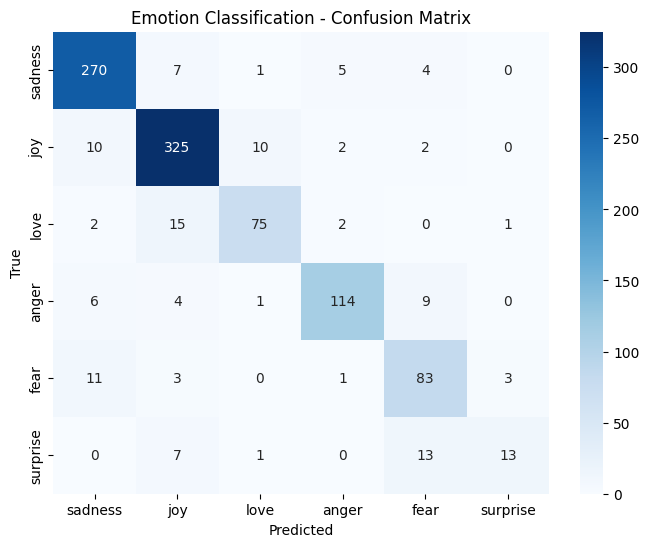

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(trues, preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(id2label.values()),
    yticklabels=list(id2label.values())
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Classification - Confusion Matrix")
plt.show()


## 1️⃣5️⃣ Training Summary Table
#### 📋 Goal: Clean epoch summary table.

In [19]:
import pandas as pd
logs = [
    row for row in trainer.state.log_history
    if "eval_accuracy" in row or "train_loss" in row
]

df = pd.DataFrame(logs)[["epoch", "train_loss", "eval_loss", "eval_accuracy", "eval_f1"]]
df.rename(columns={
    "train_loss": "Train Loss",
    "eval_loss": "Validation Loss",
    "eval_accuracy": "Accuracy",
    "eval_f1": "F1"
}, inplace=True)

df.style.set_caption("Training Summary").background_gradient(cmap="Blues")
df.style.hide(axis="index")

epoch,Train Loss,Validation Loss,Accuracy,F1
1.000000,nan,0.612226,0.812000,0.666543
2.000000,nan,0.423667,0.880000,0.805535
2.000000,0.781969,nan,nan,nan
